In [1]:
# In a new Jupyter Notebook file (e.g., visualize_perturbation.ipynb)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 1. CONFIGURATION: Set the parameters for the visualization
# ==============================================================================
# --- REQUIRED: Point this to your NetCDF output file ---
# This should be the output file from your InertialGravityWaves run.
INPUT_FILE = "/home/amir/Projects/Python/Atmpy/atmpy/output_data/inertial_gravity_long_wave/_inertial_long_wave_301_10.nc"

# --- REQUIRED: Set the time index you want to plot ---
# 0 for initial state, -1 for the last state.
TIME_INDEX_TO_PLOT = -1

# --- REQUIRED: Simulation parameters needed to reconstruct the background state ---
# These MUST match the values in your `inertial_gravity_waves.py` test case setup.
P_REF = 1e5
T_REF = 300.0
H_REF = 10000.0
T_REF_SIM = 100.0 # This is t_ref in the simulation
R_GAS = 287.4
GRAV = 9.81
NSQ_REF = 1.0e-4


if not os.path.exists(INPUT_FILE):
    print(f"ERROR: Input file not found at '{INPUT_FILE}'")
    print("Please update the INPUT_FILE variable to point to your simulation output.")
else:
    print(f"Loading data from: {INPUT_FILE}")
    ds = xr.open_dataset(INPUT_FILE)

    # Extract coordinate arrays
    x_coords = ds['x'].values
    y_coords = ds['y'].values
    print(y_coords)

    # Select the data at the desired time step
    ds_at_time = ds.isel(time=TIME_INDEX_TO_PLOT)
    time_value = ds_at_time['time'].item()
    print(f"Visualizing data at time t = {time_value:.2f} s")

Loading data from: /home/amir/Projects/Python/Atmpy/atmpy/output_data/inertial_gravity_long_wave/_inertial_long_wave_301_10.nc


/tmp/ipykernel_50808/853393816.py:35: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(INPUT_FILE)


[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
Visualizing data at time t = 30992501142.00 s


In [2]:
    # --- Calculate Total Potential Temperature (Y) from the file ---
    # This is the full field, background + perturbation
    rho_total = ds_at_time['rho']
    rhoY_total = ds_at_time['rhoY']
    # Use xarray's safe division which handles coordinates correctly
    Y_total = rhoY_total / rho_total

    # --- Reconstruct the 1D Background Potential Temperature (Y0) ---
    # This logic mimics the hydrostatic state calculation for this specific case.
    # First, calculate the scaled physical constants
    Msq = 0.1159823706796567
    g_scaled = GRAV * H_REF / (R_GAS * T_REF) / Msq
    Nsq_scaled = NSQ_REF * (T_REF_SIM ** 2)

    # Now, calculate the 1D background potential temperature profile using the known formula
    # Y0(y) = exp(Nsq * y) / g. Note that 'y' here is the non-dimensional coordinate.
    Y0_background_1d = np.exp(Nsq_scaled * y_coords / g_scaled)
    print(Y0_background_1d)
    print("Successfully reconstructed the 1D background potential temperature profile (Y0).")

    # Broadcast the 1D background Y0 to the 2D grid shape for subtraction
    # Y_total has shape (nx, ny). Y0_background_1d has shape (ny,).
    # NumPy's broadcasting rules will automatically handle the subtraction correctly.
    # Y_total (nx, ny) - Y0_background_1d (ny,) -> works as if Y0 was (1, ny)
    Y_background_2d = np.broadcast_to(Y0_background_1d[:, np.newaxis], Y_total.T.shape).T


    # --- Calculate the Perturbation Field (Y') ---
    Y_perturbation = Y_total - Y_background_2d
    print("Successfully calculated the 2D potential temperature perturbation field (Y').")

[1.00510985 1.01540802 1.0258117  1.03632197 1.04693993 1.05766668
 1.06850334 1.07945102 1.09051088 1.10168405]
Successfully reconstructed the 1D background potential temperature profile (Y0).
Successfully calculated the 2D potential temperature perturbation field (Y').


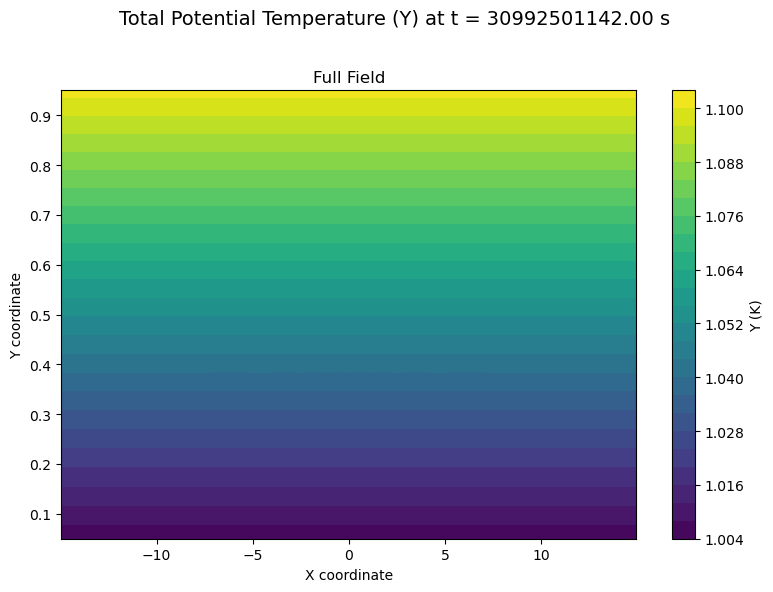

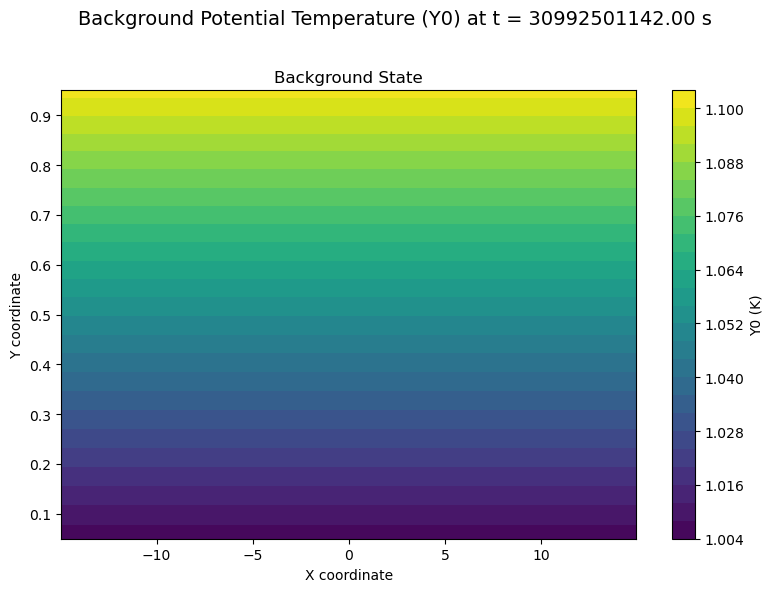

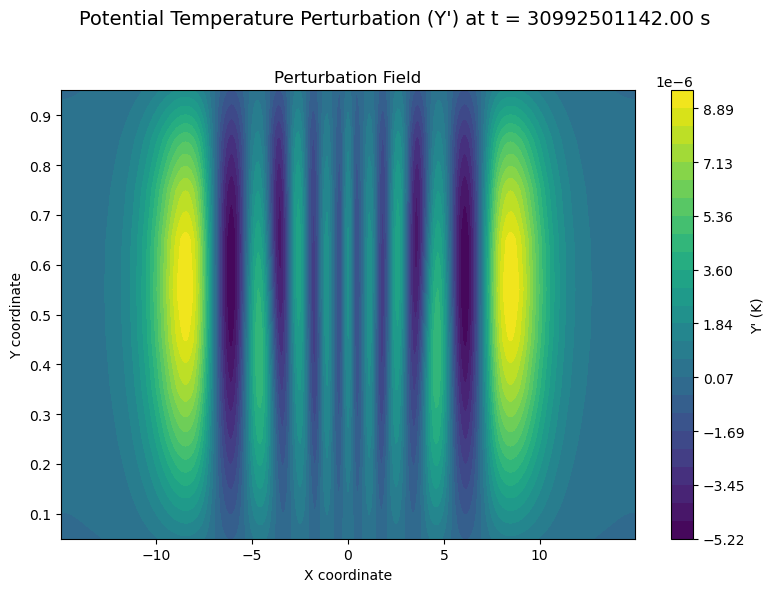

In [3]:
 # --- Figure 1: Total Potential Temperature (Y) ---
fig1, ax1 = plt.subplots(figsize=(8, 6)) # Create the first figure
fig1.suptitle(f"Total Potential Temperature (Y) at t = {time_value:.2f} s", fontsize=14)

contour1 = ax1.contourf(x_coords, y_coords, Y_total.T, levels=25, cmap='viridis')
fig1.colorbar(contour1, ax=ax1, label="Y (K)")
ax1.set_title("Full Field")
ax1.set_xlabel("X coordinate")
ax1.set_ylabel("Y coordinate")
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle


# --- Figure 2: Background Potential Temperature (Y0) ---
fig2, ax2 = plt.subplots(figsize=(8, 6)) # Create the second figure
fig2.suptitle(f"Background Potential Temperature (Y0) at t = {time_value:.2f} s", fontsize=14)

# We plot the 2D broadcasted version
contour2 = ax2.contourf(x_coords, y_coords, Y_background_2d.T, levels=25, cmap='viridis')
fig2.colorbar(contour2, ax=ax2, label="Y0 (K)")
ax2.set_title("Background State")
ax2.set_xlabel("X coordinate")
ax2.set_ylabel("Y coordinate")
plt.tight_layout(rect=[0, 0, 1, 0.96])


# --- Figure 3: Potential Temperature Perturbation (Y') ---
fig3, ax3 = plt.subplots(figsize=(8, 6)) # Create the third figure
fig3.suptitle(f"Potential Temperature Perturbation (Y') at t = {time_value:.2f} s", fontsize=14)

# Use a diverging colormap for perturbations (centered on zero)
perturb_max = Y_perturbation.max()
perturb_min = Y_perturbation.min()
# Ensure levels are symmetric around zero
levels3 = np.linspace(perturb_min, perturb_max, 26)

contour3 = ax3.contourf(x_coords, y_coords, Y_perturbation.T, levels=levels3)
fig3.colorbar(contour3, ax=ax3, label="Y' (K)")
ax3.set_title("Perturbation Field")
ax3.set_xlabel("X coordinate")
ax3.set_ylabel("Y coordinate")
plt.tight_layout(rect=[0, 0, 1, 0.96])


# --- Show all figures at once ---
# This command will display all created figures.
plt.show()

# Close the dataset
ds.close()